# FAKE NEWS CLASSIFIER

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# installing transformers
!pip install --upgrade transformers
!pip install simpletransformers
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [7]:
# using GPU
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.5 GB  |     Proc size: 651.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


In [8]:
# importing libraries
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

In [9]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
import statistics
import math
import os
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [10]:
# using CUDA 
import random
import torch
pd.options.display.max_colwidth = 200

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(2)

In [13]:
#loading dataset
d1=pd.read_csv('/content/drive/MyDrive/Fake.csv')
d1.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Bar...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned T...,News,"December 25, 2017"


In [14]:
d2=pd.read_csv('/content/drive/MyDrive/True.csv')
d2.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fis...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after Pres...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some ...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the N...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online r...",politicsNews,"December 29, 2017"


In [15]:
d1['label'] = 0 # for fake news
d2['label'] = 1 # for true news

### DATA CLEANING AND EDA

#### DATASET I

Noticed some words in fake dataset that are present in the true dataset. [BOILER ROOM:, WARNING:, FLASHBACK:, VIDEO:, WATCH!, BREAKING:, WATCH:, REPORT:, WATCH AND LAUGH:, BREAKING NEWS:, UPDATED VIDEO:, UPDATE:, SHOCKING:, POLL:, Factbox:]. These words are present in the start. e.g WATCH: Paul Ryan Just Told Us. So these words do not use for prediction (whether the news is fake or not). So making this with the empty string.

In [16]:
d1['title'] = d1['title'].str.replace('BOILER ROOM:', '')
d1['title'] = d1['title'].str.replace('WARNING:', '')
d1['title'] = d1['title'].str.replace('FLASHBACK:', '')
d1['title'] = d1['title'].str.replace('VIDEO:', '')
d1['title'] = d1['title'].str.replace('BREAKING:', '')
d1['title'] = d1['title'].str.replace('BREAKING NEWS:', '')
d1['title'] = d1['title'].str.replace('WATCH:', '')
d1['title'] = d1['title'].str.replace('REPORT: ', '')
d1['title'] = d1['title'].str.replace('WATCH AND LAUGH:', '')
d1['title'] = d1['title'].str.replace('UPDATE:', '')
d1['title'] = d1['title'].str.replace('SHOCKING:', '')
d1['title'] = d1['title'].str.replace('POLL:', '')
d1['title'] = d1['title'].str.replace('WATCH!', '')
d1['title'] = d1['title'].str.replace('UPDATED VIDEO:', '')
d1['title'] = d1['title'].str.replace('Factbox:', '')

In [17]:
d1.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Bar...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned T...,News,"December 25, 2017",0


#### DATASET II

In [18]:
# 'factbox:'. so removing them
d2['title'] = d2['title'].str.replace('Factbox:', '')

Difference in Text

Real news seems to have source of publication which is not present in fake news set

Looking at the data:

1. Most of text contains reuters information such as "WASHINGTON (Reuters)".
2. Some text are tweets from Twitter.
3. Few text do not contain any publication info.

In [19]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(d2.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of publication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [20]:
#Thus we have list of indices where publisher is not mentioned
#lets check
d2.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group of former lobbyists working in President Donald Trump’s administration who have been issued ethics waivers, following a request from the U.S. governm...
4358     Neil Gorsuch, President Donald Trump’s appointee to the U.S. Supreme Court who was confirmed by the Senate to the lifetime job on Friday in a 54-45 vote, will have an immediate impact on cases alr...
4465     WASHINGTON The clock began running out this week on a strategy that has provided U.S. Republicans in Congress with their only notable legislative successes this year: aggressive use of an obscure ...
5784     Federal appeals court judge Neil Gorsuch, the U.S. Supreme Court pick of President Donald Trump, is a conservative intellectual known for backing religious rights and seen as very much in the mold...
6660     Republican members of Congress are complaining that U.S. intelligence agencies are refusing to brief them widely on a classified CIA report that concluded 

In [21]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(d2.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [22]:
#Replace existing text column with new text
#add seperate column for publication info
d2["publisher"] = publisher
d2["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [23]:
d2.head()

,title,text,subject,date,label,publisher
0,"As U.S. budget fight looms, Republicans flip their fiscal script","The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on S...",politicsNews,"December 31, 2017",1,WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits on Monday: Pentagon,"Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s a...",politicsNews,"December 29, 2017",1,WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration a...",politicsNews,"December 31, 2017",1,WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported...",politicsNews,"December 30, 2017",1,WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized ...",politicsNews,"December 29, 2017",1,SEATTLE/WASHINGTON (Reuters)


In [24]:
d2['publisher'].value_counts()

WASHINGTON (Reuters)                                                                                                                          6389
(Reuters)                                                                                                                                     1483
LONDON (Reuters)                                                                                                                               705
NEW YORK (Reuters)                                                                                                                             695
MOSCOW (Reuters)                                                                                                                               623
                                                                                                                                              ... 
ERBIL/LONDON, Iraq (Reuters)                                                                                          

In [25]:
d2.drop(['publisher'], axis=1, inplace=True)
d2.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip their fiscal script","The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on S...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits on Monday: Pentagon,"Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s a...",politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration a...",politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported...",politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized ...",politicsNews,"December 29, 2017",1


In [26]:
# combining the two datasets or concatenating the two dataset.
frame = [d1, d2]
df = pd.concat(frame)
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Bar...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned T...,News,"December 25, 2017",0


In [27]:
df.shape

(44898, 5)

In [28]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [29]:
# dropping duplicates
df = df.drop_duplicates()

In [30]:
# resetting the index
df.reset_index(inplace=True)

In [31]:
# after dropping the duplicates, i get 44689 no of rows. So total no of duplicates present in the dataset = 209
df.shape

(44689, 6)

In [32]:
df.columns

Index(['index', 'title', 'text', 'subject', 'date', 'label'], dtype='object')

In [33]:
df['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [34]:
df['label'].value_counts()

0    23478
1    21211
Name: label, dtype: int64

In [35]:
# dropping unnecessary columns. 
df.drop(['subject', 'date'], axis = 1, inplace=True)
df.head()

,index,title,text,label
0,0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",0
1,1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",0
2,2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",0
3,3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Bar...",0
4,4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned T...,0


In [36]:
df['combine']= df['title'] +' '+ df['text']
df.head()

,index,title,text,label,combine
0,0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout..."
1,1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",0,"Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us,..."
2,2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",0,"Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homel..."
3,3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Bar...",0,"Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES) On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the..."
4,4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned T...,0,Pope Francis Just Called Out Donald Trump During His Christmas Speech Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivere...


In [37]:
# dropping unnecessary columns. 
df.drop(['index', 'title', 'text'], axis = 1, inplace=True)
df.head()

,label,combine
0,0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout..."
1,0,"Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us,..."
2,0,"Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homel..."
3,0,"Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES) On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the..."
4,0,Pope Francis Just Called Out Donald Trump During His Christmas Speech Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivere...


In [38]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [39]:
# applying that into function.
df["text"] = df['combine'].apply(lambda x: clean_text(x))
df.head(10)

,label,combine,text
0,0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout...",Donald Trump Sends Out Embarrassing New Year s Eve Message This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that Instead he had to give a shout out...
1,0,"Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us,...",Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day He s been under the assumption like many of us tha...
2,0,"Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homel...",Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People In The Eye On Friday it was revealed that former Milwaukee Sheriff David Clarke who was being considered for Homeland S...
3,0,"Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES) On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the...",Trump Is So Obsessed He Even Has Obama s Name Coded Into His Website On Christmas day Donald Trump announced that he would be back to work the following day but he is golfing for the fourth day in...
4,0,Pope Francis Just Called Out Donald Trump During His Christmas Speech Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivere...,Pope Francis Just Called Out Donald Trump During His Christmas Speech Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name The Pope delivered ...
5,0,"Racist Alabama Cops Brutalize Black Boy While He Is In Handcuffs (GRAPHIC IMAGES) The number of cases of cops brutalizing and killing people of color seems to see no end. Now, we have another cas...",Racist Alabama Cops Brutalize Black Boy While He Is In Handcuffs The number of cases of cops brutalizing and killing people of color seems to see no end Now we have another case that needs to be s...
6,0,"Fresh Off The Golf Course, Trump Lashes Out At FBI Deputy Director And James Comey Donald Trump spent a good portion of his day at his golf club, marking the 84th day he s done so since taking th...",Fresh Off The Golf Course Trump Lashes Out At FBI Deputy Director And James Comey Donald Trump spent a good portion of his day at his golf club marking the th day he s done so since taking the oat...
7,0,"Trump Said Some INSANELY Racist Stuff Inside The Oval Office, And Witnesses Back It Up In the wake of yet another court decision that derailed Donald Trump s plan to bar Muslims from entering the...",Trump Said Some INSANELY Racist Stuff Inside The Oval Office And Witnesses Back It Up In the wake of yet another court decision that derailed Donald Trump s plan to bar Muslims from entering the U...
8,0,"Former CIA Director Slams Trump Over UN Bullying, Openly Suggests He’s Acting Like A Dictator (TWEET) Many people have raised the alarm regarding the fact that Donald Trump is dangerously close t...",Former CIA Director Slams Trump Over UN Bullying Openly Suggests He s Acting Like A Dictator Many people have raised the alarm regarding the fact that Donald Trump is dangerously close to becoming...
9,0,Brand-New Pro-Trump Ad Features So Much A** Kissing It Will Make You Sick Just when you might have thought we d get a break from watching people kiss Donald Trump s ass and stroke his ego ad nau...,Brand New Pro Trump Ad Features So Much A Kissing It Will Make You Sick Just when you might have thought we d get a break from watching p

In [40]:
# dropping the uncleaned text column "combine"
df = df.drop(['combine'], axis=1)

In [41]:
df['label'].value_counts()

0    23478
1    21211
Name: label, dtype: int64

This is perfectly balanced dataset

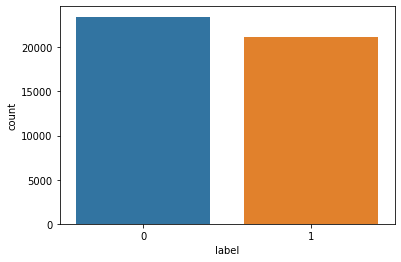

In [42]:
import seaborn as sns
sns.countplot('label',data=df)

In [43]:
df.head()

,label,text
0,0,Donald Trump Sends Out Embarrassing New Year s Eve Message This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that Instead he had to give a shout out...
1,0,Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day He s been under the assumption like many of us tha...
2,0,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People In The Eye On Friday it was revealed that former Milwaukee Sheriff David Clarke who was being considered for Homeland S...
3,0,Trump Is So Obsessed He Even Has Obama s Name Coded Into His Website On Christmas day Donald Trump announced that he would be back to work the following day but he is golfing for the fourth day in...
4,0,Pope Francis Just Called Out Donald Trump During His Christmas Speech Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name The Pope delivered ...


### MODEL BUILDING - (ROBERTA CLASSIFIER) Robustly Optimized BERT approach

In [45]:
import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

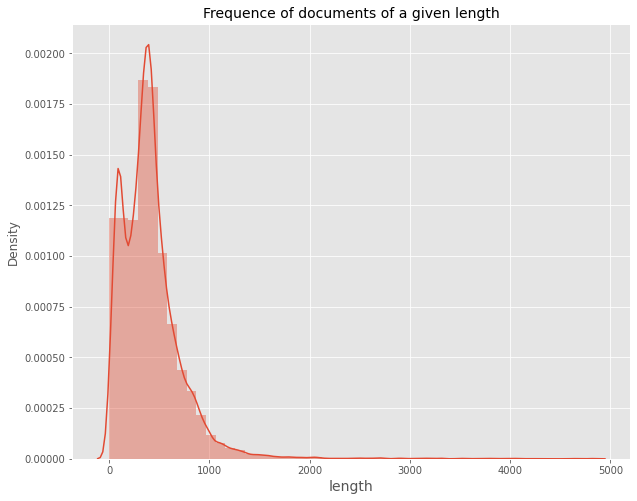

In [46]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['length'] = df['text'].apply(lambda x: len(x.split()))
sns.distplot(df[df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

In [47]:
# cropped the data to max length of the model.
df['text'] = df['text'].apply(lambda x: " ".join(x.split()[:512]))
df['text']

0        Donald Trump Sends Out Embarrassing New Year s Eve Message This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that Instead he had to give a shout out...
1        Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day He s been under the assumption like many of us tha...
2        Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People In The Eye On Friday it was revealed that former Milwaukee Sheriff David Clarke who was being considered for Homeland S...
3        Trump Is So Obsessed He Even Has Obama s Name Coded Into His Website On Christmas day Donald Trump announced that he would be back to work the following day but he is golfing for the fourth day in...
4        Pope Francis Just Called Out Donald Trump During His Christmas Speech Pope Francis used his annual Christmas Day message to rebuke Donald Trump without eve

In [48]:
df.to_csv('data.csv', index=False)

In [49]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [50]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [51]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [52]:
PAD_INDEX

1

In [53]:
UNK_INDEX

3

In [54]:
# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'text' : ('text', text_field), 'label' : ('label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path=f"/content/data.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='label')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.text), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [55]:
train_data

In [56]:
test_data

In [57]:
train_iter

In [58]:
test_iter

In [60]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [61]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x

In [62]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [63]:
output_path = '/content/output_path'

In [64]:
# Training Function

def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        #output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        #loss = output[0]
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [65]:
# Main training loop
NUM_EPOCHS = 2
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.4)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 3
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


======================= Start pretraining ==============================
Epoch [1/2], global step [1956/3912], PT Loss: 0.6566, Val Loss: 0.6644
Epoch [2/2], global step [3912/3912], PT Loss: 0.4725, Val Loss: 0.1983
Pre-training done!
======================= Start training =================================
Epoch [1/3], global step [1956/5868], Train Loss: 0.1573, Valid Loss: 0.0189
Epoch [2/3], global step [3912/5868], Train Loss: 0.0170, Valid Loss: 0.0072
Epoch [3/3], global step [5868/5868], Train Loss: 0.0092, Valid Loss: 0.0060
Training done!


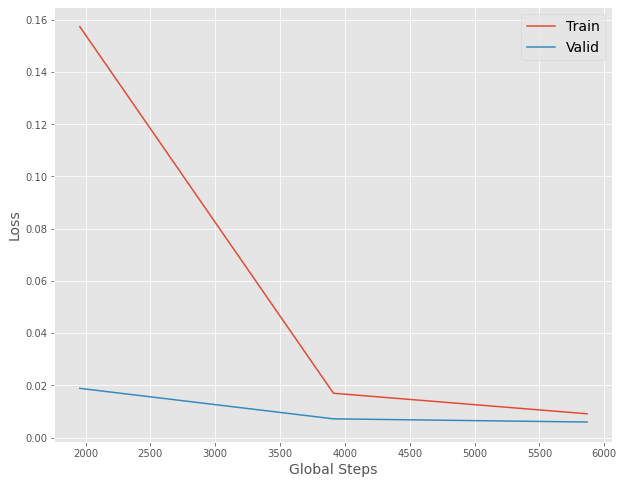

In [66]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [69]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [70]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classification Report:
              precision    recall  f1-score   support

           1     0.9993    1.0000    0.9996      4242
           0     1.0000    0.9994    0.9997      4696

    accuracy                         0.9997      8938
   macro avg     0.9996    0.9997    0.9997      8938
weighted avg     0.9997    0.9997    0.9997      8938



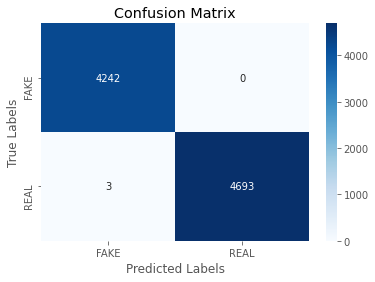

In [71]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)